# Imports

In [18]:
import typing
import random
import math
import sklearn.datasets
import sklearn.preprocessing
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import PIL
import os
import os.path
from tensorflow import keras
import enum
import dataclasses

# Matrix operations

In [2]:
"""
(row, col)
"""
class Matrix:
    def __init__(
        self,
        row_count: int,
        col_count: int,
        data: list[float],
    ):
        assert row_count * col_count == len(data)
        self.__row_count = row_count
        self.__col_count = col_count
        self.__data = data
    
    def __repr__(self) -> str:
        return str([
            self.__data[row_index * self.__col_count:(row_index+1) * self.__col_count]
            for row_index in range(self.__row_count)
        ])
    
    @classmethod
    def from_numpy(
        self,
        array: np.ndarray,
    ) -> 'Matrix':
        assert len(array.shape) == 2
        row_count = array.shape[0]
        col_count = array.shape[1]
        data = array.flatten().tolist()
        
        result = Matrix(
            row_count,
            col_count,
            data,
        )
        
        return result
    
    @classmethod
    def from_func(
        self,
        row_count: int,
        col_count: int,
        func: typing.Callable[[int, int], float]
    ) -> 'Matrix':
        data = []
        
        for row_index in range(row_count):
            for col_index in range(col_count):
                data.append(func(row_index, col_index))
        
        result = Matrix(
            row_count,
            col_count,
            data,
        )
        
        return result
    
    def __getitem__(self, key) -> float:
        if (
            isinstance(key, tuple) and len(key) == 2
            and
            isinstance(key[0], int)
            and
            isinstance(key[1], int)
            and
            key[0] >= 0 and key[0] < self.__row_count
            and
            key[1] >= 0 and key[1] < self.__col_count
        ):
            return self.__data[key[0]*self.__col_count + key[1]]
            
        raise ValueError()
    
    @property
    def col_count(self) -> int:
        return self.__col_count
    
    @property
    def row_count(self) -> int:
        return self.__row_count
    
    def get_row(self, index) -> 'Matrix':
        assert index >= 0 and index < self.__row_count
        data = self.__data[index*self.__col_count:(index+1)*self.__col_count]
        
        result = Matrix(
            1,
            self.__col_count,
            data,
        )
        
        return result
    
    def __mul__(self, other) -> 'Matrix':
        if isinstance(other, int):
            other = float(other)
        
        if isinstance(other, Matrix):
            assert self.__col_count == other.__row_count, f"Different lhs col_count={self.__col_count} and rhs row_count={other.__row_count}"
            mid_count = self.__col_count
            
            result_data = []
            for i in range(self.__row_count):
                for j in range(other.__col_count):
                    result_data_value = 0
                    for k in range(mid_count):
                        result_data_value += self[(i, k)]*other[(k, j)]
                    result_data.append(result_data_value)
            
            result = Matrix(
                self.__row_count,
                other.__col_count,
                result_data,
            )
            
            return result
        
        if isinstance(other, float):
            result_data = []
            for value in self.__data:
                result_data.append(value * other)
            
            result = Matrix(
                self.__row_count,
                self.__col_count,
                result_data,
            )
            
            return result
        
        assert False
    
    def __rmul__(self, other: 'Matrix') -> 'Matrix':
        if isinstance(other, int):
            return self.__mul__(other)
        if isinstance(other, float):
            return self.__mul__(other)
        
        assert False, f"Invalid __rmul__ between '{type(self)}' and '{type(other)}'"
    
    def __add__(self, other: 'Matrix') -> 'Matrix':
        if isinstance(other, Matrix):
            assert self.__row_count == other.__row_count
            assert self.__col_count == other.__col_count
            row_count = self.__row_count
            col_count = self.__col_count

            result_data = []
            for self_value, other_value in zip(self.__data, other.__data):
                result_data.append(self_value + other_value)

            result = Matrix(
                row_count,
                col_count,
                result_data,
            )

            return result
            
        assert False
    
    def __iadd__(self, other: 'Matrix'):
        if isinstance(other, Matrix):
            assert self.__row_count == other.__row_count
            assert self.__col_count == other.__col_count
            row_count = self.__row_count
            col_count = self.__col_count
            
            for index in range(row_count * col_count):
                self.__data[index] += other.__data[index]
            
            return self
        
        assert False
    
    def __sub__(self, other) -> 'Matrix':
        if isinstance(other, Matrix):
            assert self.__row_count == other.__row_count
            assert self.__col_count == other.__col_count
            row_count = self.__row_count
            col_count = self.__col_count

            result_data = []
            for self_value, other_value in zip(self.__data, other.__data):
                result_data.append(self_value - other_value)

            result = Matrix(
                row_count,
                col_count,
                result_data,
            )

            return result
            
        assert False
    
    def piecewise_mul(self, other: 'Matrix') -> 'Matrix':
        assert self.__row_count == other.__row_count, f"Different lhs row_count={self.__row_count} and rhs row_count={other.row_count}"
        assert self.__col_count == other.__col_count
        row_count = self.__row_count
        col_count = self.__col_count
        
        result_data = []
        for self_value, other_value in zip(self.__data, other.__data):
            result_data.append(self_value * other_value)
        
        result = Matrix(
            row_count,
            col_count,
            result_data,
        )
        
        return result
    
    def transpose(self) -> 'Matrix':
        result_data = []
        
        for col_index in range(self.__col_count):
            for row_index in range(self.__row_count):
                result_data.append(self[(row_index, col_index)])
        
        result = Matrix(
            self.__col_count,
            self.__row_count,
            result_data,
        )
                                   
        return result
    
    def map(self, func: typing.Callable[[float], float]) -> 'Matrix':
        result_data = []
        
        for value in self.__data:
            result_data.append(func(value))
        
        result = Matrix(
            self.__row_count,
            self.__col_count,
            result_data,
        )
        
        return result

# Data

## Iris

In [3]:
iris = sklearn.datasets.load_iris()

iris_input = iris["data"]
iris_output = iris["target"]
iris_output_idk = (
    np.stack(
        [
            iris_output == 0,
            iris_output == 1,
            iris_output == 2,
        ],
        1,
    ).astype(float)
)

## Digits

In [4]:
digits = sklearn.datasets.load_digits()

digits_input = digits["data"]
digits_output = digits["target"]
digits_output_idk = (
    np.stack(
        [
            digits_output == 0,
            digits_output == 1,
            digits_output == 2,
            digits_output == 3,
            digits_output == 4,
            digits_output == 5,
            digits_output == 6,
            digits_output == 7,
            digits_output == 8,
            digits_output == 9,
        ],
        1,
    ).astype(float)
)

## Images

In [71]:
original_images_path = "./data/images/original/"
regular_images_path = "./data/images/processed/regular/"
sepia_images_path = "./data/images/processed/sepia/"

In [74]:
@dataclasses.dataclass
class ImageSample:
    regular: np.ndarray
    sepia: np.ndarray

image_samples = []

if False:
    for image_entry in os.scandir(original_images_path):
        if not image_entry.is_file():
            continue

        image_path = os.path.join(original_images_path, image_entry.name)
        with PIL.Image.open(image_path) as image:
            image: PIL.Image = image
            regular_image = image.resize((48, 48))

            regular_image_array = np.asarray(regular_image)
            sepia_image_array = np.zeros_like(regular_image_array)

            sepia_image_array = np.clip(
                np.stack(
                    [
                        regular_image_array.dot(np.array([0.393, 0.769, 0.189])),
                        regular_image_array.dot(np.array([0.349, 0.686, 0.168])),
                        regular_image_array.dot(np.array([0.272, 0.534, 0.131])),
                    ],
                    axis=2,
                ),
                0, 255,
            ).astype(np.uint8)

            sepia_image = PIL.Image.fromarray(sepia_image_array)

            regular_image.save(os.path.join(regular_images_path, image_entry.name))
            sepia_image.save(os.path.join(sepia_images_path, image_entry.name))
        
for image_entry in os.scandir(regular_images_path):
    with PIL.Image.open(os.path.join(regular_images_path, image_entry.name)) as regular_image:
        with PIL.Image.open(os.path.join(sepia_images_path, image_entry.name)) as sepia_image:
            image_samples.append(
                ImageSample(
                    np.asarray(regular_image),
                    np.asarray(sepia_image),
                )
            )

# Solution

In [6]:
def sigmoid(x: float):
    return 1 / (1 + math.exp(-x))

def sigmoid_d(x: float):
    return sigmoid(x) * (1 - sigmoid(x))

## Neural network

In [7]:
class NeuralNetwork:
    def __init__(
        self,
        layers_config: list[int],
        *,
        learning_rate: float,
    ):
        self.__learning_rate = learning_rate
        self.__w = [None] + [
            Matrix.from_func(
                curr_layer,
                prev_layer,
                # lambda row_index, col_index: random.random(),
                lambda row_index, col_index: 0,
            )
            for prev_layer, curr_layer
            in zip(layers_config, layers_config[1:])
        ]
        self.__b = [None] + [
            Matrix.from_func(
                layer,
                1,
                # lambda row_index, col_index: random.random(),
                lambda row_index, col_index: 0,
            )
            for layer in layers_config[1:]
        ]
    
    @property
    def layer_count(self) -> int:
        return len(self.__w)
    
    def calculate_activation(
        self,
        sample: Matrix,
    ) -> (list[Matrix], list[Matrix]):
        activation = [sample] + [None] * (self.layer_count - 1)
        inner = [None] * self.layer_count
        for layer_index in range(1, self.layer_count):
            inner[layer_index] = (
                self.__w[layer_index] * activation[layer_index - 1]
                +
                self.__b[layer_index]
            )
            
            activation[layer_index] = (
                inner[layer_index].map(lambda value: sigmoid(value))
            )
        
        return activation, inner
    
    def fit_sample(
        self,
        sample: Matrix,
        correct: Matrix,
    ):
        activation, inner = self.calculate_activation(sample)
        
        # print("=== inner")
        # for value in inner:
        #     if value is None:
        #         print(value)
        #         continue
        #     print(value.row_count, value.col_count)
         
        # print(activation[-1] - correct)
            
        delta = (
            [None] * (self.layer_count - 1)
            +
            [
                (activation[-1] - correct)
                .piecewise_mul
                (inner[-1].map(lambda value: sigmoid_d(value)))
            ]
        )
        
        # print("===")
        for layer_index in reversed(range(1, self.layer_count - 1)):
            # print(layer_index)
            delta[layer_index] = (
                (
                    self.__w[layer_index + 1].transpose()
                    *
                    delta[layer_index + 1]
                ).piecewise_mul(
                    inner[layer_index].map(
                        lambda value: sigmoid_d(value),
                    )
                )
            )
        
        # print("=== activation")
        # for value in activation:
        #     print(value.row_count, value.col_count)
        # print("=== delta")
        # for delta_value in delta:
        #     if delta_value is None:
        #         print(delta_value)
        #         continue
        #     print(delta_value.row_count, delta_value.col_count)
        
        # print("===")
        for layer_index in range(1, self.layer_count):
            # print(activation[layer_index - 1].row_count, activation[layer_index - 1].col_count)
            # print(delta[layer_index].row_count, delta[layer_index].col_count)
            
            # dingus = (self.__learning_rate * -1) * activation[layer_index - 1] * delta[layer_index].transpose()
            
            # print(dingus.row_count, dingus.col_count)
            # print(self.__w[layer_index].row_count, self.__w[layer_index].col_count)
            
            # print(b.row_count, b.col_count)
            self.__b[layer_index] += (self.__learning_rate * -1) * delta[layer_index]
            self.__w[layer_index] += ((self.__learning_rate * -1) * activation[layer_index - 1] * delta[layer_index].transpose()).transpose()
    
    def debug(self):
        print(self.__b)
        print(self.__w)

In [8]:
def solve_ann(
    neural_network: NeuralNetwork,
    input_full: np.ndarray,
    output_full: np.ndarray,
    output_idk_full: np.ndarray,
    *,
    class_names: list[str],
    iterations_count: int,
):
    test_percent = 0.20
    class_count = len(class_names)
    
    assert len(input_full) == len(output_full)
    assert len(input_full) == len(output_idk_full)
    length = len(input_full)
    
    output_full = output_full.reshape((length, 1))
    
    # shuffle data
    indices = np.arange(length)
    np.random.shuffle(indices)
    
    input_full = input_full[indices]
    output_full = output_full[indices]
    output_idk_full = output_idk_full[indices]
    
    # split into train and test
    split_index = int(length * test_percent)
    
    ## test
    input_test = input_full[:split_index]
    output_test = output_full[:split_index]
    output_idk_test = output_idk_full[:split_index]

    ## train
    input_train = input_full[split_index:]
    output_train = output_full[split_index:]
    output_idk_train = output_idk_full[split_index:]
    
    # normalize
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(input_train)
    input_train = scaler.transform(input_train)
    input_test = scaler.transform(input_test)
    
    # convert to Matrix
    
    ## test
    input_test = Matrix.from_numpy(input_test)
    output_test = Matrix.from_numpy(output_test)
    output_idk_test = Matrix.from_numpy(output_idk_test)

    ## train
    input_train = Matrix.from_numpy(input_train)
    output_train = Matrix.from_numpy(output_train)
    output_idk_train = Matrix.from_numpy(output_idk_train)
    
    # lengths
    test_length = split_index
    train_length = length - split_index

    for generation_index in range(iterations_count):
        print(generation_index)
        for row_index in range(train_length):
            neural_network.fit_sample(
                input_train.get_row(row_index).transpose(),
                output_idk_train.get_row(row_index).transpose(),
            )
            # print(iris_output.get_row(row_index).transpose())

    # nn.debug()
    
    confusion_matrix = [
        [0 for _ in range(class_count)]
        for _ in range(class_count)
    ]

    for row_index in range(test_length):
        activation, inner = neural_network.calculate_activation(
            input_test.get_row(row_index).transpose(),
        )
        activation = activation[-1]
        
        correct_class = output_test[(row_index, 0)]
        chosen_class = max(list(range(class_count)), key=lambda class_index: activation[(class_index, 0)])
        
        confusion_matrix[correct_class][chosen_class] += 1
    
    # plot confusion matrix
    plt.figure()
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = "Blues")
    plt.colorbar()
    plt.xticks(range(class_count), class_names, rotation=45)
    plt.yticks(range(class_count), class_names)
    for row_index in range(class_count):
        for col_index in range(class_count):
            plt.text(
                col_index, row_index,
                format(confusion_matrix[row_index][col_index], "d"),
                horizontalalignment = "center",
                color = "white" if confusion_matrix[row_index][col_index] > 1 else "black",
            )

## Iris

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


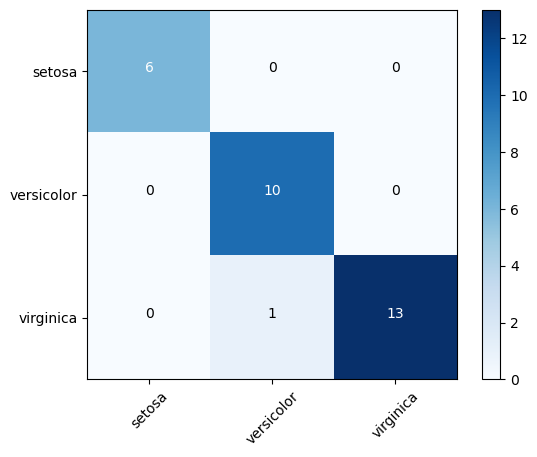

In [68]:
solve_ann(
    NeuralNetwork(
        [4, 16, 16, 3],
        learning_rate=0.5,
    ),
    iris_input,
    iris_output,
    iris_output_idk,
    class_names=iris["target_names"],
    iterations_count=25,
)

## Digits

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


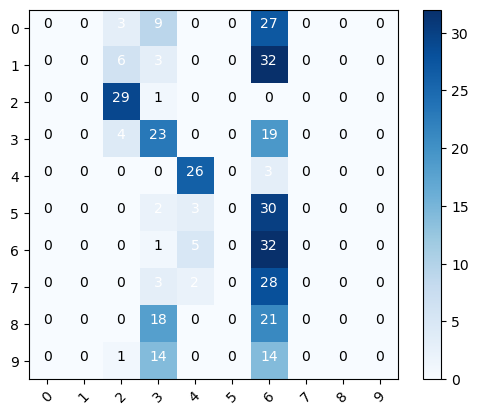

In [69]:
solve_ann(
    NeuralNetwork(
        [64, 16, 16, 10],
        learning_rate=0.5,
    ),
    digits_input,
    digits_output,
    digits_output_idk,
    class_names=digits["target_names"],
    iterations_count=25,
)

## Sepia

### ANN

In [75]:
length = len(image_samples)
    
images_output = np.full(length, 0)
split_percentage = 0.50
split_index = int(length * split_percentage)
images_output[split_index:] = 1
np.random.shuffle(images_output)

images_input = np.stack(
    [
        image_samples[i].regular if images_output[i] == 0 else image_samples[i].sepia
        for i in range(length)
    ]
)
images_output_labels = np.stack(
    [
        images_output == 0,
        images_output == 1,
    ],
    1,
).astype(float)

test_percent = 0.80

length = len(image_samples)
    
images_output = np.full(length, 0)
split_percentage = 0.50
split_index = int(length * split_percentage)
images_output[split_index:] = 1
np.random.shuffle(images_output)

images_input = np.stack(
    [
        image_samples[i].regular if images_output[i] == 0 else image_samples[i].sepia
        for i in range(length)
    ]
) / 255
images_output_labels = np.stack(
    [
        images_output == 0,
        images_output == 1,
    ],
    1,
).astype(float)

test_percent = 0.20

# shuffle data
indices = np.arange(length)
np.random.shuffle(indices)

images_input = images_input[indices]
images_output = images_output[indices]
images_output_labels = images_output_labels[indices]

# split into train and test
split_index = int(length * test_percent)

## test
input_test = images_input[:split_index]
output_test = images_output[:split_index]
output_labels_test = images_output_labels[:split_index]

## train
input_train = images_input[split_index:]
output_train = images_output[split_index:]
output_labels_train = images_output_labels[split_index:]

# train model
model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    input_train, output_labels_train,
    validation_data=(input_test, output_labels_test),
    # class_weight = class_weight,
    epochs=32,
    batch_size=64,
)
model.summary()

Epoch 1/32
2/2 [==============================] - 1s 152ms/step - loss: 0.7558 - accuracy: 0.4737 - val_loss: 0.8126 - val_accuracy: 0.6667
Epoch 2/32
2/2 [==============================] - 0s 23ms/step - loss: 1.3047 - accuracy: 0.4079 - val_loss: 1.0431 - val_accuracy: 0.3333
Epoch 3/32
2/2 [==============================] - 0s 27ms/step - loss: 0.7873 - accuracy: 0.4868 - val_loss: 0.6433 - val_accuracy: 0.6111
Epoch 4/32
2/2 [==============================] - 0s 27ms/step - loss: 0.6332 - accuracy: 0.6974 - val_loss: 0.7872 - val_accuracy: 0.3889
Epoch 5/32
2/2 [==============================] - 0s 29ms/step - loss: 0.6225 - accuracy: 0.5921 - val_loss: 0.5759 - val_accuracy: 0.5556
Epoch 6/32
2/2 [==============================] - 0s 34ms/step - loss: 0.6914 - accuracy: 0.4474 - val_loss: 0.5802 - val_accuracy: 0.7778
Epoch 7/32
2/2 [==============================] - 0s 35ms/step - loss: 0.5868 - accuracy: 0.7105 - val_loss: 0.9558 - val_accuracy: 0.3889
Epoch 8/32
2/2 [==========

### CNN

In [65]:
length = len(image_samples)
    
images_output = np.full(length, 0)
split_percentage = 0.50
split_index = int(length * split_percentage)
images_output[split_index:] = 1
np.random.shuffle(images_output)

images_input = np.stack(
    [
        image_samples[i].regular if images_output[i] == 0 else image_samples[i].sepia
        for i in range(length)
    ]
)
images_output_labels = np.stack(
    [
        images_output == 0,
        images_output == 1,
    ],
    1,
).astype(float)

test_percent = 0.80

length = len(image_samples)
    
images_output = np.full(length, 0)
split_percentage = 0.50
split_index = int(length * split_percentage)
images_output[split_index:] = 1
np.random.shuffle(images_output)

images_input = np.stack(
    [
        image_samples[i].regular if images_output[i] == 0 else image_samples[i].sepia
        for i in range(length)
    ]
) / 255
images_output_labels = np.stack(
    [
        images_output == 0,
        images_output == 1,
    ],
    1,
).astype(float)

test_percent = 0.20

# shuffle data
indices = np.arange(length)
np.random.shuffle(indices)

images_input = images_input[indices]
images_output = images_output[indices]
images_output_labels = images_output_labels[indices]

# split into train and test
split_index = int(length * test_percent)

## test
input_test = images_input[:split_index]
output_test = images_output[:split_index]
output_labels_test = images_output_labels[:split_index]

## train
input_train = images_input[split_index:]
output_train = images_output[split_index:]
output_labels_train = images_output_labels[split_index:]

# train model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    input_train, output_labels_train,
    validation_data=(input_test, output_labels_test),
    # class_weight = class_weight,
    epochs=32,
    batch_size=64,
)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 flatten_32 (Flatten)        (None, 4096)            